# Neural Networks - implementation from scratch 

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# sklearn
from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay


In [12]:
# fully - connected layer
class FCLayer:
    def __init__(self, input_size, output_size):
        self.input = None
        self.output = None
        # uniform distribution [0, 1] - 0.5 -> [-0.5, 0.5]
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5
        
    # forward propagation: 
    # compute output Y of the layer for a given input X
    def forward_propagation(self, input):
        self.input = input
        # Y = XW + B
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output
        
    # backward propagation: 
    # compute dE/dW, dE/dB (update weights+bias) for a given output_error=dE/dY
    # return input_error=dE/dX
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        
        # update parameters
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        
        return input_error

In [13]:
# activation layer
class ActivationLayer:
    def __init__(self, activation, activation_prime):
        self.input = None
        self.output = None
        self.activation = activation
        self.activation_prime = activation_prime
    
    # forward propagation:
    # return the activated input (activation fcn applied on input)
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output
    
    # backward propagation:
    # return input_error=dE/dX for a given output_error=dE/dY
    # learning_rate not used, there are no parameters to update
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

In [14]:
# activation function and its derivative
def tanh(x):
    return np.tanh(x);

def tanh_prime(x):
    return 1-np.tanh(x)**2;

In [15]:
# loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

In [28]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None
        
    # add layer to the network
    def add(self, layer):
        self.layers.append(layer)
        
    # set loss function
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime
        
    # predict output for given input
    def predict(self, input_data):
        samples = len(input_data) # input size
        result = []
        
        # run network for all samples
        for i in range(0, samples):
            # forward propagation
            output = input_data[i] # i-th sample
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)
            
        return result
    
    
    # train the network
    def fit(self, x_train, y_train, epochs, learning_rate):
        samples = len(x_train) # length of the training set
        err_vect = np.zeros(epochs)
        # training loop
        for i in range(0, epochs):
            err = 0
            for j in range(0, samples): # through all training samples
                # forward propagation
                output = x_train[j]  # x_train will be 3D and first dimension will correspond to index
                for layer in self.layers:
                    output = layer.forward_propagation(output)
                    
                # compute loss
                err += self.loss(y_train[j], output)
                
                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)
            
            # average error per sample
            err /= samples
            err_vect[i] = err
            # print('epoch %d/%d   error=%f' % (i+1, epochs, err))
        return err_vect

    def plot_error_curve(self, err_vect):
        plt.figure(figsize=(10, 6))
        plt.plot(np.arange(1, len(err_vect)+1, 1), err_vect, '-', color='darkblue')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.title('Average error per sample through training epochs')
        
    def nn_evaluate(self, x_train, y_train, x_test, y_test, epochs, learning_rate):
        net.fit(x_train, y_train, epochs, learning_rate)
        
        y_train_pred = net.predict(x_train)
        y_train_pred = np.concatenate(y_train_pred).flatten()
        y_train_pred = np.round(y_train_pred).astype(int) # classification problem
        
        y_test_pred = net.predict(x_test)
        y_test_pred = np.concatenate(y_test_pred).flatten()
        y_test_pred = np.round(y_test_pred).astype(int)   # classification problem
        
        y_train = np.concatenate(y_train).flatten()
        y_test = np.concatenate(y_test).flatten()
        # accuracy
        print("#"*50)
        print("Accuracy on train: ", accuracy_score(y_true=y_train, y_pred=y_train_pred))
        print("Accuracy on test: ", accuracy_score(y_true=y_test, y_pred=y_test_pred))
        # recall
        print("#"*50)
        print("Recall on train: ", recall_score(y_true=y_train, y_pred=y_train_pred))
        print("Recall on test: ", recall_score(y_true=y_test, y_pred=y_test_pred))
        # precision
        print("#"*50)
        print("Precision on train: ", precision_score(y_true=y_train, y_pred=y_train_pred))
        print("Precision on test: ", precision_score(y_true=y_test, y_pred=y_test_pred))
    
        # plot confusion matrices
        print("#"*50)
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

        c_1 = confusion_matrix(y_true=y_train, y_pred=y_train_pred)
        cmd_1 = ConfusionMatrixDisplay(c_1, display_labels=['0', '1'])
        cmd_1.plot(ax=ax[0], cmap=plt.cm.Blues)
        ax[0].set_title("Confusion matrix: train data")

        c_2 = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
        cmd_2 = ConfusionMatrixDisplay(c_2, display_labels=['0', '1'])
        cmd_2.plot(ax=ax[1], cmap=plt.cm.Blues)
        ax[1].set_title("Confusion matrix: test data")

        plt.tight_layout()
        plt.suptitle("Neural Network: our implementation", fontsize=15, ha='center')
        plt.subplots_adjust(top=0.85)

        plt.show()
        
        

### Example

[array([[0.00078623]]), array([[0.97762671]]), array([[0.97779351]]), array([[-0.00140822]])]


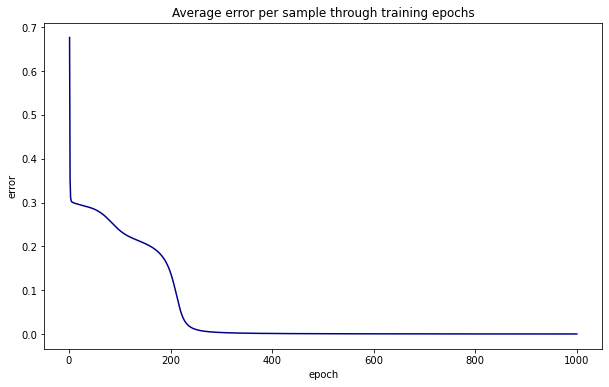

In [33]:
# building NN

# training data
x_train = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
y_train = np.array([[[0]], [[1]], [[1]], [[0]]])

# network
net = Network()
net.add(FCLayer(2, 3))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(3, 1))
net.add(ActivationLayer(tanh, tanh_prime))

# train
net.use(mse, mse_prime)
err_vect = net.fit(x_train, y_train, epochs=1000, learning_rate=0.1)
net.plot_error_curve(err_vect)

# test
out = net.predict(x_train)
print(out)

In [30]:
# Conversion to 1D numpy array
print(out)
print(np.concatenate(out))
print(np.concatenate(out).flatten())

[array([[0.52337426]]), array([[0.52672906]]), array([[0.51518898]]), array([[0.51859501]])]
[[0.52337426]
 [0.52672906]
 [0.51518898]
 [0.51859501]]
[0.52337426 0.52672906 0.51518898 0.51859501]


##################################################
Accuracy on train:  1.0
Accuracy on test:  1.0
##################################################
Recall on train:  1.0
Recall on test:  1.0
##################################################
Precision on train:  1.0
Precision on test:  1.0
##################################################


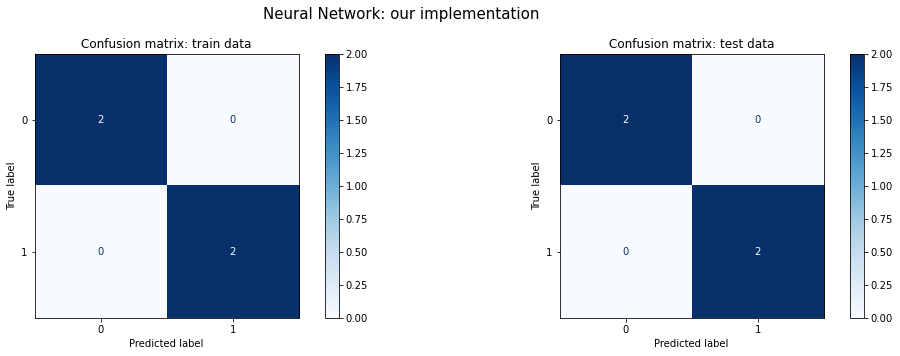

In [34]:
net.nn_evaluate(x_train=x_train, y_train=y_train, x_test=x_train, y_test=y_train, epochs=1000, learning_rate=0.1)

### Example: Iris dataset

In [35]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)


In [36]:
print(X_train.shape)
print(X_test.shape)

(120, 4)
(30, 4)


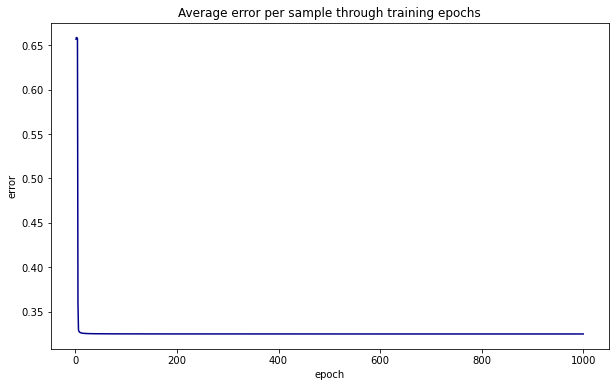

In [37]:
# network
net = Network()
net.add(FCLayer(4, 3))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(3, 1))
net.add(ActivationLayer(tanh, tanh_prime))

# train
net.use(mse, mse_prime)
# reshape first, such that every row becomes separate array
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
y_train = y_train.reshape(y_train.shape[0], 1, 1)

X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
y_test = y_test.reshape(y_test.shape[0], 1, 1)

err_vect = net.fit(X_train, y_train, epochs=1000, learning_rate=0.1)
net.plot_error_curve(err_vect)

In [38]:
net.nn_evaluate(x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test, epochs=1000, learning_rate=0.1)

##################################################
Accuracy on train:  0.675
Accuracy on test:  0.6333333333333333
##################################################


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].